In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## <b> 0. Bert Hyperparameters </b>

In [52]:
random_state_split = 42
Dropout_num = 0
learning_rate = 5.95e-6
valid = 0.15
epochs_num = 3
batch_size_num = 16
target_corrected = False
target_big_corrected = False

In [2]:
%cd drive/MyDrive/Colab Notebooks/disaster_tweets

/content/drive/MyDrive/Colab Notebooks/disaster_tweets


## <b> 1. Import Libraries </b>

In [58]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')

import string
import re
import gensim

from wordcloud import WordCloud

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant

import torch

import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ImportError: ignored

## <b> 2. Download Data </b>

In [4]:
train= pd.read_csv('./data/train.csv')
test=pd.read_csv('./data/test.csv')
submission = pd.read_csv("./data/sample_submission.csv")

In [5]:
print('There are {} rows and {} columns in train'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


In [6]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


## <b> 3. EDA </b>

Class distribution

In [7]:
# extracting the number of examples of each class
Real_len = train[train['target'] == 1].shape[0]
Not_len = train[train['target'] == 0].shape[0]

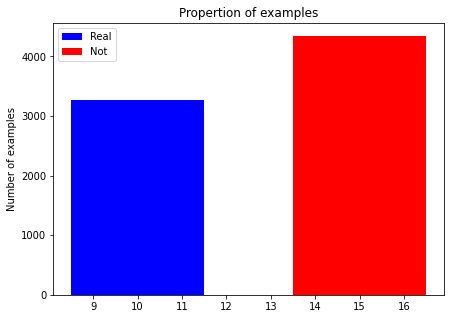

In [8]:
# bar plot of the 3 classes
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,Real_len,3, label="Real", color='blue')
plt.bar(15,Not_len,3, label="Not", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

<b> Number of characters in tweets </b>

In [9]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)

In [10]:
train['length'] = train['text'].apply(length)

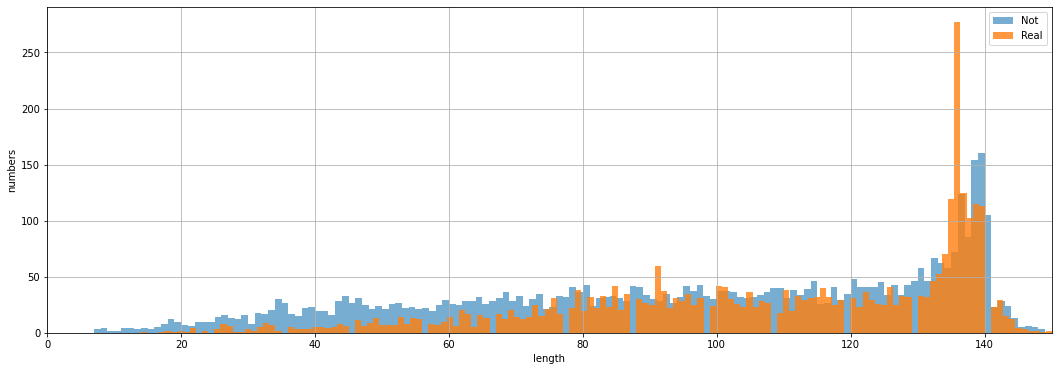

In [11]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(train[train['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Not')
plt.hist(train[train['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

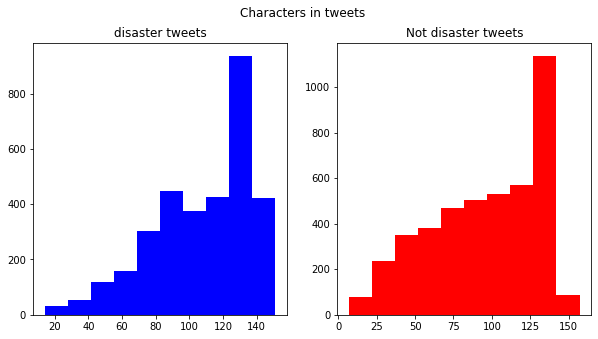

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_len=train[train['target']==1]['text'].str.len()
ax1.hist(train_len,color='blue')
ax1.set_title('disaster tweets')
train_len=train[train['target']==0]['text'].str.len()
ax2.hist(train_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

<b> Number of words in a tweet </b>

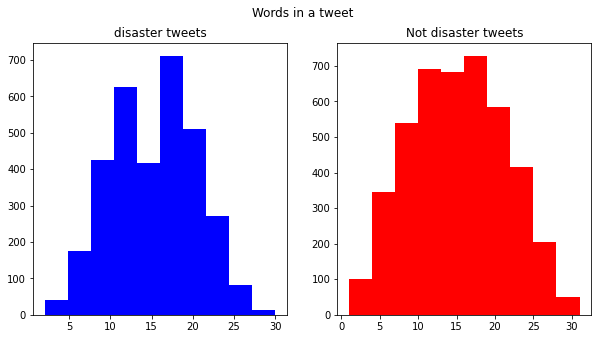

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(train_len,color='blue')
ax1.set_title('disaster tweets')
train_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(train_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

<b> Average word length in a tweet </b>

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each tweet')

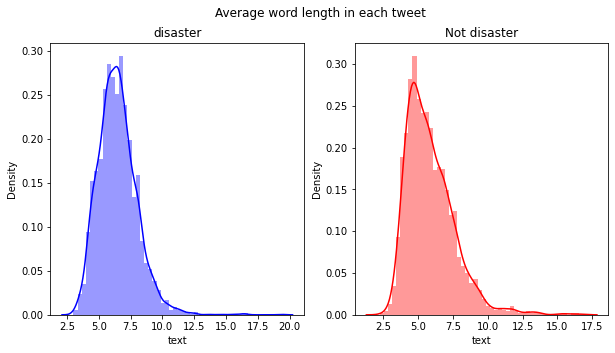

In [14]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [15]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [16]:
def create_corpus_df(tweet, target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<b> Common Stopwords In Tweets </b>

In [17]:
stop=set(stopwords.words('english'))

In [18]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

In [19]:
# displaying the stopwords
np.array(stop)

array({"you'll", 'an', 'but', 'or', 'on', 'just', 'her', "should've", 'if', 'after', 'you', 'only', 'now', 'mightn', "that'll", 'a', 'your', "it's", 'its', 'themselves', "wasn't", 'are', 'both', 'wasn', 'won', "isn't", "you've", 'how', 'their', 'than', 'isn', "shan't", 'had', 'has', 'whom', 'of', 'his', 'such', 'himself', 'don', 'he', 'itself', 'ourselves', 't', 'in', 'shan', 'about', 'can', 'out', 'wouldn', "you're", 'couldn', 'under', 'between', 'ours', 'this', 'doing', 'as', 'o', 'why', 'by', 'ain', 'few', "she's", 'same', 'been', 'more', 'who', "mustn't", 'were', "mightn't", 'yours', 'they', 'at', 've', "didn't", 'm', 'where', 'should', 'with', 'doesn', 'very', "you'd", 'that', 'not', 'me', 'some', 'until', 'have', 'myself', 'before', "weren't", 'over', 'it', 'did', 'once', 'was', 'most', 'and', "wouldn't", 'during', 'while', "don't", 'other', 's', 'above', 'yourself', 'is', 'there', "won't", 'y', "shouldn't", "couldn't", 'because', 'off', 'my', 'to', 'yourselves', 'which', "needn'

<BarContainer object of 10 artists>

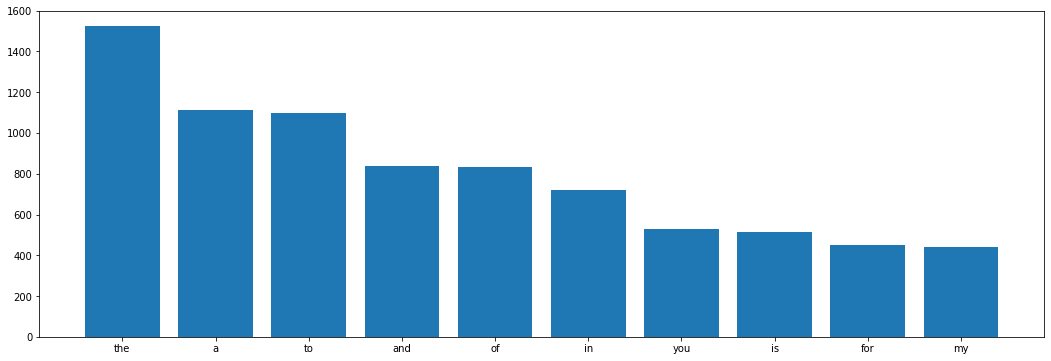

In [20]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

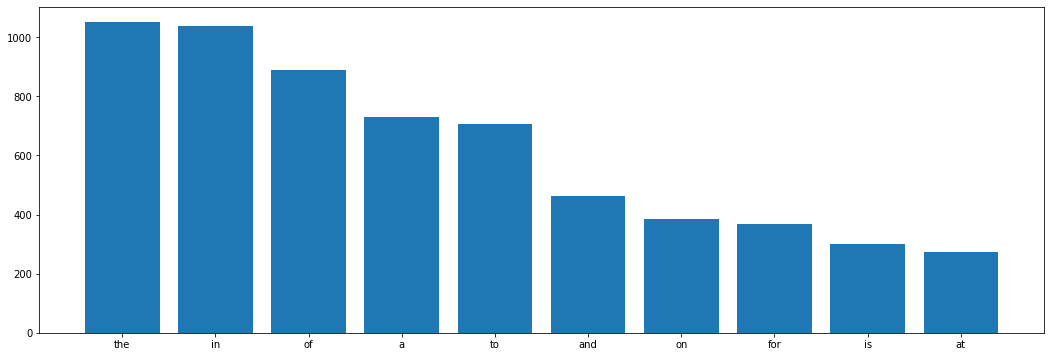

In [21]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

<b> Analyzing punctuations </b>

<BarContainer object of 18 artists>

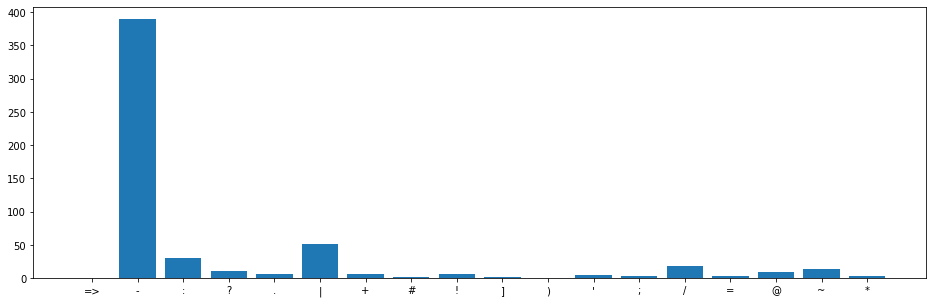

In [22]:
plt.figure(figsize=(16,5))
corpus=create_corpus(1)

dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

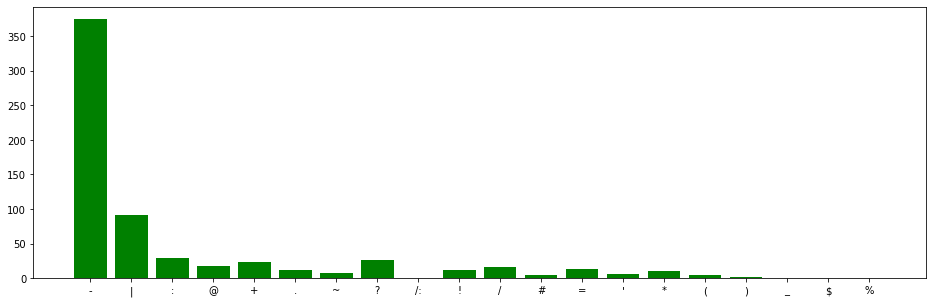

In [23]:
plt.figure(figsize=(16,5))
corpus=create_corpus(0)
dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

<b> Common Words </b>

In [24]:
plt.figure(figsize=(16,5)) 
counter=Counter(corpus) # target_value = 0
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

<Figure size 1152x360 with 0 Axes>

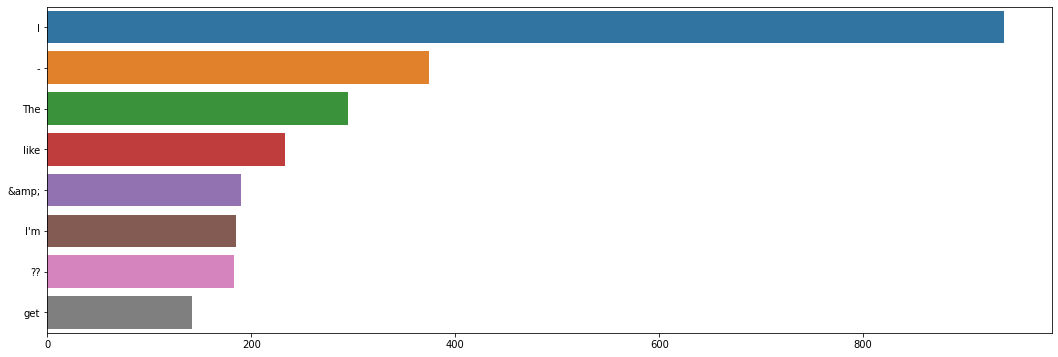

In [25]:
sns.barplot(x=y,y=x)

<b> N-gram analysis </b>

In [26]:
# reference : https://datascienceschool.net/03%20machine%20learning/03.01.03%20Scikit-Learn%EC%9D%98%20%EB%AC%B8%EC%84%9C%20%EC%A0%84%EC%B2%98%EB%A6%AC%20%EA%B8%B0%EB%8A%A5.html
def get_top_train_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    # print(vec.vocabulary_)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) # column(단어) 별로 모든 행 합산 
    # print(sum_words)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True) # value 값(빈도수)을 기준으로 정렬을 하라는 의미
    # print(words_freq)
    return words_freq[:n]

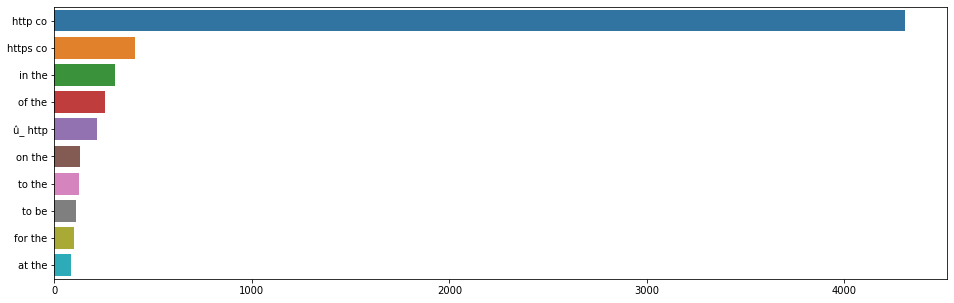

In [27]:
plt.figure(figsize=(16,5))
top_train_bigrams=get_top_train_bigrams(train['text'])[:10]
x,y=map(list,zip(*top_train_bigrams))
sns.barplot(x=y,y=x)

## <b> 4. Data Cleaning </b>

Thanks to https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

In [28]:
df=pd.concat([train, test])
df.shape

(10876, 6)

<b> Removing urls </b>

In [33]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [34]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [ ]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

<b> Removing HTML tags </b>

In [35]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [36]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [37]:
df['text']=df['text'].apply(lambda x : remove_html(x))

<b> Removing Emojis </b>


In [38]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [39]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

<b> Removing punctuations </b>


In [40]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [41]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

## <b> 5. WordCloud </b>

<b> Real Disaster </b>

In [42]:
corpus_new1=create_corpus_df(df, 1)
len(corpus_new1)

49613

In [43]:
corpus_new1[:10]

['Our',
 'Deeds',
 'are',
 'the',
 'Reason',
 'of',
 'this',
 '#earthquake',
 'May',
 'ALLAH']

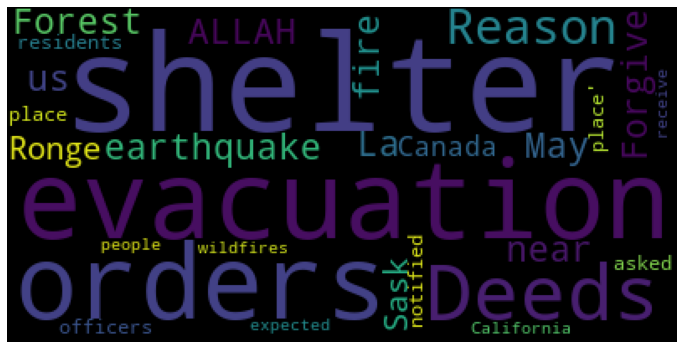

In [46]:
# Generating the wordcloud with the values under the category dataframe
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                       ).generate(" ".join(corpus_new1[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [47]:
df.head(10)

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0,69.0
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1.0,38.0
2,5,NaN,NaN,All residents asked to shelter in place are be...,1.0,133.0
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1.0,65.0
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1.0,88.0
5,8,NaN,NaN,RockyFire Update California Hwy 20 closed in ...,1.0,110.0
6,10,NaN,NaN,flood disaster Heavy rain causes flash floodin...,1.0,95.0
7,13,NaN,NaN,Im on top of the hill and I can see a fire in ...,1.0,59.0
8,14,NaN,NaN,Theres an emergency evacuation happening now i...,1.0,79.0
9,15,NaN,NaN,Im afraid that the tornado is coming to our area,1.0,52.0


## <b> 6. Bag of Words Counts </b>

Thanks to https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb

In [63]:
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = df["text"].tolist()
list_labels = df["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=random_state_split)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

  (0, 7529)	1
  (0, 16898)	1
  (0, 6732)	1
  (0, 4695)	1
  (0, 22687)	1
  (0, 7110)	1
  (1, 8302)	1
  (1, 24552)	3
  (1, 1142)	1
  (1, 17246)	1
  (1, 1437)	1
  (1, 15474)	1
  (1, 22683)	1
  (1, 20375)	1
  (1, 22453)	1
  (1, 24278)	1
  (1, 1711)	1
  (1, 23922)	1
  (1, 23971)	1
  (1, 7461)	1
  (1, 1124)	1
  (1, 22073)	1
  (1, 24569)	1
  (1, 2372)	1
  (1, 20774)	1
  :	:
  (8698, 21498)	1
  (8698, 1903)	1
  (8698, 16634)	1
  (8698, 18744)	1
  (8698, 2797)	1
  (8698, 17652)	1
  (8698, 8083)	1
  (8698, 4583)	1
  (8698, 10649)	1
  (8698, 11182)	1
  (8699, 22687)	1
  (8699, 22683)	1
  (8699, 17532)	1
  (8699, 2271)	1
  (8699, 24032)	1
  (8699, 14355)	1
  (8699, 7927)	1
  (8699, 6752)	1
  (8699, 22618)	1
  (8699, 1110)	1
  (8699, 24060)	1
  (8699, 24506)	1
  (8699, 6016)	1
  (8699, 16750)	1
  (8699, 10283)	1


<b> Visualizing the embeddings </b>

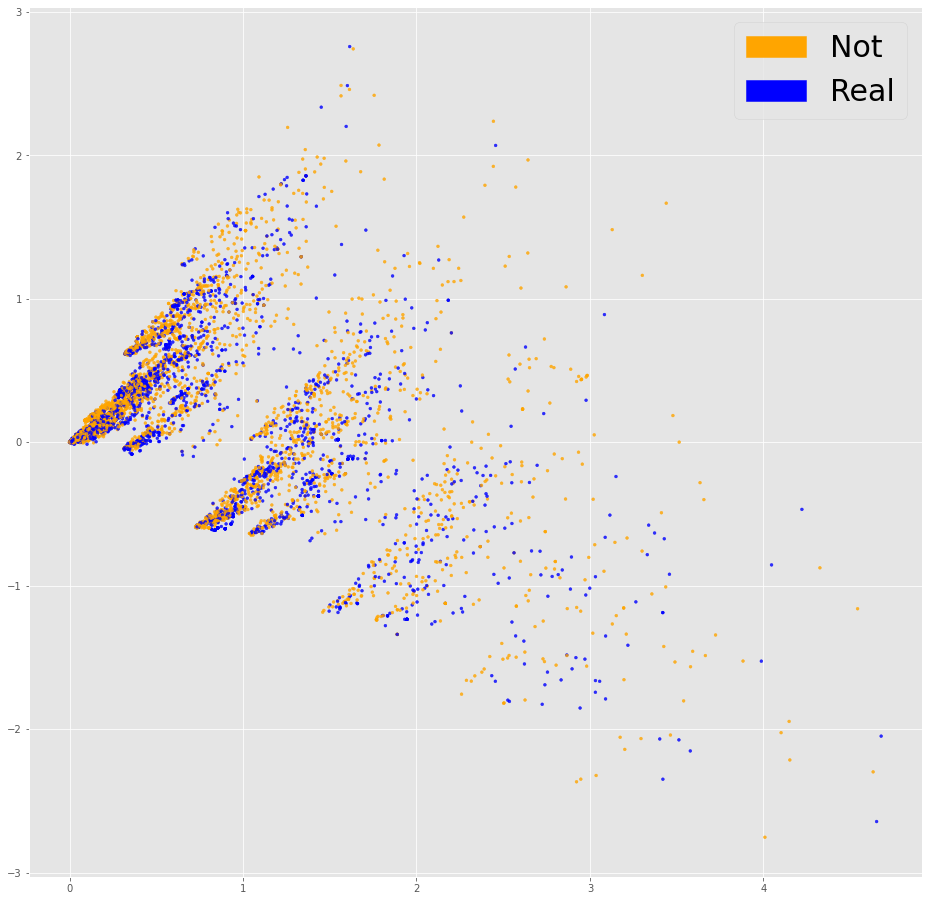

In [59]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['orange','blue']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
        orange_patch = mpatches.Patch(color='orange', label='Not')
        blue_patch = mpatches.Patch(color='blue', label='Real')
        plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()